In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from xgboost import XGBRegressor

from sklearn.impute import SimpleImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score

from pandas.api.types import is_string_dtype

import warnings
warnings.filterwarnings('ignore')

%config InlineBackend.figure_format = 'svg'

In [2]:
path = 'melbourne-housing-market/'
file = 'Melbourne_housing_FULL.csv'

df_all = pd.read_csv(path+file)

In [3]:
for col in df_all.columns:
    try:
        df_all[col] = pd.to_numeric(df_all[col])
    except:
        print(col, len(set(df_all[col])))

Suburb 351
Address 34009
Type 3
Method 9
SellerG 388
Date 78
CouncilArea 34
Regionname 9


In [4]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34857 entries, 0 to 34856
Data columns (total 21 columns):
Suburb           34857 non-null object
Address          34857 non-null object
Rooms            34857 non-null int64
Type             34857 non-null object
Price            27247 non-null float64
Method           34857 non-null object
SellerG          34857 non-null object
Date             34857 non-null object
Distance         34856 non-null float64
Postcode         34856 non-null float64
Bedroom2         26640 non-null float64
Bathroom         26631 non-null float64
Car              26129 non-null float64
Landsize         23047 non-null float64
BuildingArea     13742 non-null float64
YearBuilt        15551 non-null float64
CouncilArea      34854 non-null object
Lattitude        26881 non-null float64
Longtitude       26881 non-null float64
Regionname       34854 non-null object
Propertycount    34854 non-null float64
dtypes: float64(12), int64(1), object(8)
memory usage: 5.6+ M

In [5]:
# Drop data without target column
df = df_all[df_all.Price.notnull()]

In [6]:
# separate out month and year
df['month'] =[date.split('/')[1] for date in df['Date']]#
df['year'] =[float(date.split('/')[2]) for date in df['Date']]

In [7]:
# Seperate categorical from numerical data
categorical_cols = df.select_dtypes(exclude = [np.number])
numerical_cols = df.select_dtypes(include = [np.number])

In [8]:
# Check which columns have missing values and how many
df.isna().sum()

Suburb               0
Address              0
Rooms                0
Type                 0
Price                0
Method               0
SellerG              0
Date                 0
Distance             1
Postcode             1
Bedroom2          6441
Bathroom          6447
Car               6824
Landsize          9265
BuildingArea     16591
YearBuilt        15163
CouncilArea          3
Lattitude         6254
Longtitude        6254
Regionname           3
Propertycount        3
month                0
year                 0
dtype: int64

In [9]:
len(numerical_cols.columns.difference(['Price']))

13

IndexError: index 4 is out of bounds for axis 0 with size 4

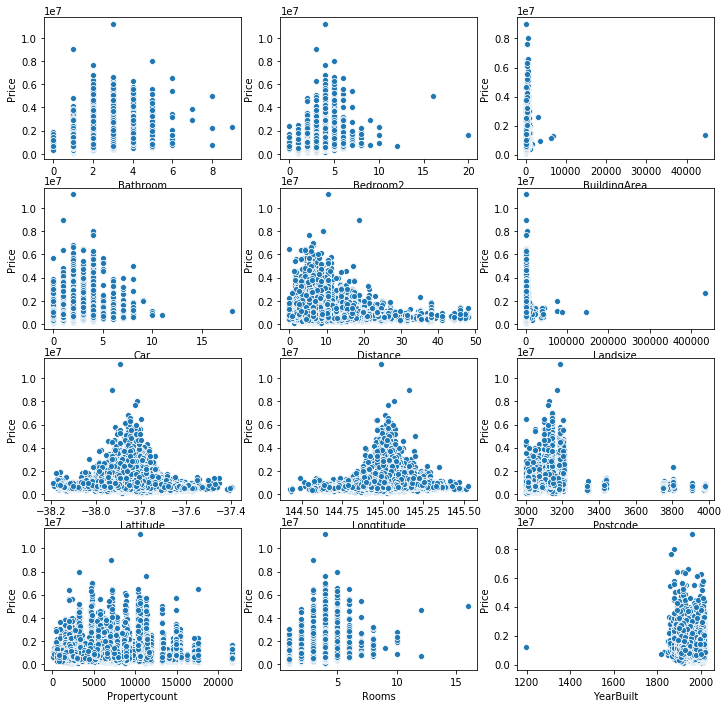

In [11]:

%config InlineBackend.figure_format = 'png'
fig, axes = plt.subplots(4, 3, figsize=(12, 12))

for ik, feat in enumerate(numerical_cols.columns.difference(['Price'])):
    ax = axes[int(ik / 3), ik%3]
    sns.scatterplot(x=feat, y='Price', data=numerical_cols, ax=ax);
    ax.set_xlabel(feat)
    ax.set_ylabel('Price')
    
fig.tight_layout();



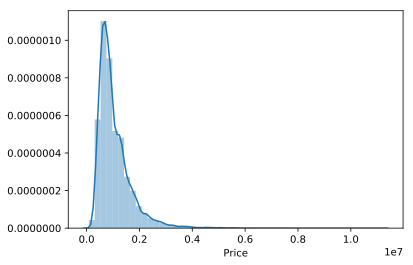

In [12]:
%config InlineBackend.figure_format = 'svg'
sns.distplot(df['Price'])

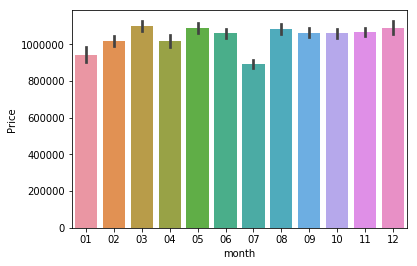

In [192]:
sns.barplot(x="month", y="Price", data=df)

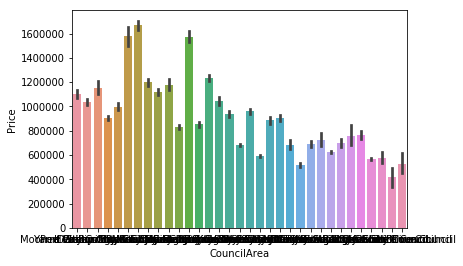

In [193]:
sns.barplot(x="CouncilArea", y="Price", data=df)

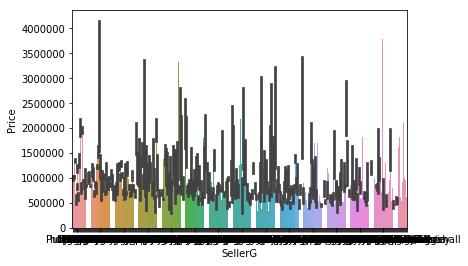

In [194]:
sns.barplot(x="SellerG", y="Price", data=df)

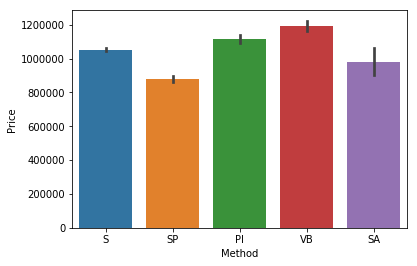

In [196]:
sns.barplot(x="Method", y="Price", data=df)

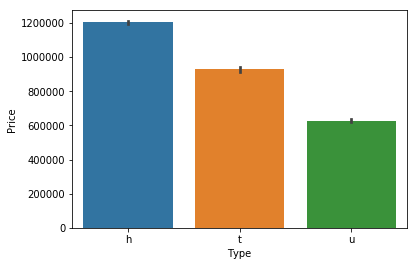

In [197]:
sns.barplot(x="Type", y="Price", data=df)

-  Either will need to drop columns to get rid of missing values or impute
-->  Did not improve model results to drop features.  Better results from dropping rows  
df = df.drop(['BuildingArea', 'YearBuilt','Landsize'], axis=1)

# Two approaches for feature set  + modeling

In [13]:
df2 = df.dropna()

In [14]:
target = 'Price'
X = df2.loc[:, ~(df2.columns).isin([target])]
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

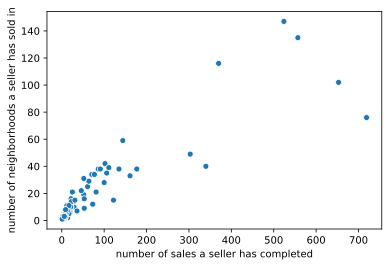

In [15]:
grps = X_train.groupby(['SellerG'])
seller_counts = []
seller_neighborhoods = []

for grp in grps:
#     print(grp[0], len(set(grp[1].Suburb)))
    seller_counts.append(len(grp[1]))
    seller_neighborhoods.append(len(set(grp[1].Suburb)))
#     break

ax = sns.scatterplot(seller_counts, seller_neighborhoods)
ax.set_xlabel('number of sales a seller has completed')
ax.set_ylabel('number of neighborhoods a seller has sold in')

## Approach 1: make dummy variables out of categorical variables
- Make each categorical variable into a set of dummy variables
- Pick the top 50 sellers in the training set as a set of seller variables and discard the rest

In [16]:
# Identify top sellers as potential features
# Is price affected by selling agent?
top_sellers = X_train.groupby(['SellerG'])
seller_totals = []
sellers = []

for seller in top_sellers:
    sellers.append(seller[0])
    seller_totals.append(len(seller[1]))
    
df_tmp = pd.DataFrame({'seller': sellers, 'counts': seller_totals})

top_sellers = df_tmp.sort_values(by = 'counts', ascending = False).head(50)['seller']

In [17]:
#Approach 1 to prepping training set: Make dummy variables

# make dummy variables for categories
break_out = ['Regionname', 'Method', 'Type', 'month', 'SellerG', 'CouncilArea'] #'CouncilArea', 'SellerG','Postcode'
for col in break_out:
    X_train = pd.concat([X_train, pd.get_dummies(X_train[col],prefix=col)], axis=1)
    
target = 'Price'
omit = ['Date', 'Address', 'Regionname', 'Suburb','Method', 'Type', 'month', 'SellerG', 'CouncilArea']

#keep the top 50 sellers in the training set
seller_labels = ['SellerG_'+seller for seller in top_sellers]
omit_sellers = [ col for col in X_train.columns if ('SellerG_' in col) & (col not in seller_labels)]

In [18]:
X_train = X_train.loc[:, ~(X_train.columns).isin([target]+omit+ break_out+ omit_sellers)]

In [19]:
# Apply variable practices to test set
for col in break_out:
    X_test = pd.concat([X_test, pd.get_dummies(X_test[col],prefix=col)], axis=1)

omit_sellers = [ col for col in X_test.columns if ('SellerG_' in col) & (col not in seller_labels)]

X_test = X_test.loc[:, ~(X_test.columns).isin([target]+omit+ break_out+ omit_sellers)]
print(len(y_test), X_test.shape)

overlap = list(set(X_test.columns).intersection(set(X_train.columns))) 
empties = [col for col in X_train.columns if col not in overlap]

empty_df = pd.DataFrame(0, index=X_test.index, columns=empties)

X_test = pd.concat([X_test[overlap], empty_df], axis=1, join_axes=[X_test.index])


2222 (2222, 123)


In [20]:
from sklearn import linear_model
lin_reg = linear_model.LinearRegression()
lin_reg.fit(X_train, y_train)
print(cross_val_score(lin_reg, X_train, y_train))

lin_reg.score(X_test, y_test)

[ 0.69532056  0.71148826  0.64873751]


-580007.17068181338

In [21]:
from sklearn.preprocessing import StandardScaler

#Standardize the data before feeding it to PCA algorithm
scaler_X = StandardScaler()
scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = y_train
y_test_scaled = y_test

#Use PCA algorithm to reduce the number of features to speed up training 
pca = PCA(.95)
pca.fit(X_train_scaled)

X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
y_train_scaled_pca = y_train
y_test_scaled_pca = y_test


In [22]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, nthread=10)
model.fit(X_train_scaled_pca, y_train_scaled_pca, early_stopping_rounds=5, eval_set=[(X_test_scaled_pca, y_test_scaled_pca)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=10, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [23]:
model.score(X_test_scaled_pca,y_test_scaled_pca )

-0.0038786047564483006

In [24]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, nthread=10)
model.fit(X_train_scaled, y_train_scaled, early_stopping_rounds=5, eval_set=[(X_test_scaled, y_test_scaled)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=10, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [25]:
model.score(X_test_scaled,y_test_scaled )

-0.016476562396544603

In [ ]:
# That was a disaster...

## Approach 2 to feature set: different approach to categorical variables

In [26]:
# Found a nifty trick for transforming categorical variables to numerical variables
for col, col_data in df2.items():
    if is_string_dtype(col_data):
        df2[col] = df2[col].astype('category').cat.as_ordered().cat.codes

In [386]:
# With only 23 variables, let's look at a heat map

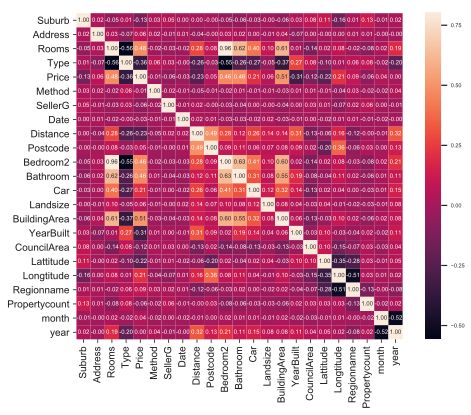

In [27]:
corrmat = df2.corr()
f, ax = plt.subplots(figsize=(8, 6))
sns.set(font_scale=0.5)
sns.heatmap(corrmat,annot=True, square=True, fmt='.2f', vmax=.8);

In [ ]:
# Looked through the heatmap and tested the model against removing a few features.  Picked up some points.

In [28]:
target = 'Price'
X = df2.loc[:, ~(df2.columns).isin([target]+ ['Date', 'Address','SellerG'])]
Y = df2[target]

X_train, X_test, y_train, y_test = train_test_split(X, Y)

In [29]:
from sklearn.preprocessing import StandardScaler

#Standardize the data before feeding it to PCA algorithm
scaler_X = StandardScaler()
scaler_X.fit(X_train)

X_train_scaled = scaler_X.transform(X_train)
X_test_scaled = scaler_X.transform(X_test)
y_train_scaled = y_train
y_test_scaled = y_test

#Use PCA algorithm to reduce the number of features to speed up training 
pca = PCA(.95)
pca.fit(X_train_scaled)

X_train_scaled_pca = pca.transform(X_train_scaled)
X_test_scaled_pca = pca.transform(X_test_scaled)
y_train_scaled_pca = y_train
y_test_scaled_pca = y_test

In [30]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.05, nthread=10)
model.fit(X_train_scaled, y_train_scaled, early_stopping_rounds=5, eval_set=[(X_test_scaled, y_test_scaled)], verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=1000,
       n_jobs=1, nthread=10, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [31]:
model.score(X_test_scaled,y_test_scaled )

0.84252457041168705

In [32]:
#Validate the trained model using validation data-set
cvt = cross_val_score(model, X_train_scaled, y_train_scaled)

mae = cross_val_score(model, X_test_scaled, y_test_scaled, scoring = 'neg_mean_absolute_error')

print("Model Accuracy:\t",cvt.mean())
print("\nMean Absolute Error:\t",(-1 * mae.mean()))

Model Accuracy:	 0.819529206509

Mean Absolute Error:	 175171.365086


In [33]:
predict_y = model.predict(X_test_scaled)

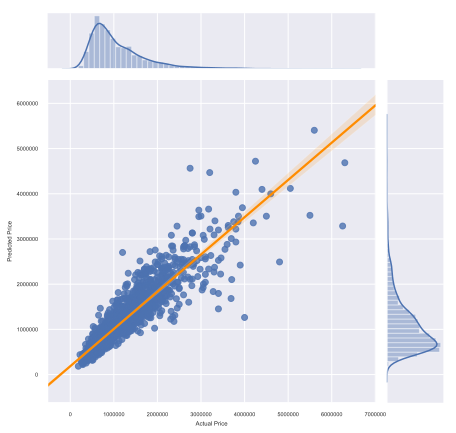

In [34]:
#Plot the actual Price value against predicted Sale Price 
g = sns.jointplot(x= y_test_scaled, y= predict_y, kind='reg',
                  joint_kws={'line_kws':{'color':'darkorange'}})
g.set_axis_labels(xlabel='Actual Price', ylabel='Predicted Price')

In [351]:
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

svr = SVR()
svr.fit(X_train_scaled, y_train_scaled)

print(svr.score(X_test_scaled, y_test_scaled))
# print(cross_val_score(svr, X_train_scaled, y_train_scaled))


-0.0756500141385
